# **Table of Contents**

* **[Introduction](#introduction)**
* **[Importing Necessary Libraries](#import-necessary-libraries)**
* **[Data Loading](#data-loading)**
* **[External Data Integration](#external-data-integration)**
* **[Data Cleaning](#data-cleaning)**
* **[Exploratory Data Analysis (EDA)](#exploratory-data-analysis)**
    - [Target Distribution (total_users)](#target-distribution)
    - [Categorical Features](#categorical-features)
    - [Numerical Features](#numerical-features)
    - [Correlation Heatmap](#correlation-heatmap)
    - [Summary of Findings](#summary-of-findings)

* **[Data Preprocessing](#data-preprocessing)**
    - [Handling Missing Values](#handling-missing-values)
    - [Handling Outliers](#handling-outliers)
    - [Label Encoding](#label-encoding)

* **[Feature Engineering](#feature-engineering)**
    - [Add Features](#add-features)
    - [reducing multicollinearity](#reducing-multicollinearity)

* **[Evaluating Different Models](#evaluating-different-models)**
* **[Final Model Training](#final-model-training)**
* **[Submission File Creation](#submission-file-creation)**

## **Introduction**


In this task, we aim to develop a **regression model** that predicts the total number of daily bike rentals (`total_users`) based on various weather, seasonal, and calendar features.

This competition is part of the Data Science Project for University of Tehran students and is hosted on [Kaggle](https://www.kaggle.com/t/cafa0ac99d2b4b72b6b2ef736a4a51a7). The dataset contains real-world data collected on a daily basis, but **this is not a time series forecasting problem**. Instead, temporal and environmental features are used to explain rental patterns.

- Objective: Predict the **`total_users`** (sum of casual and registered users) for each day in the test set.
- Evaluation Metric: The main evaluation metric is **Mean Squared Error (MSE)**:


The dataset includes the following features:

| Column Name         | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| `id`                | Unique identifier for each record (starting from 1)                         |
| `date`              | Calendar date (DD-MM-YYYY)                                                  |
| `season_id`         | Categorical value for season (Spring, Summer, etc.)                         |
| `year`              | 0 for 2018, 1 for 2019                                                      |
| `month`             | Month of the year (1–12)                                                    |
| `is_holiday`        | 1 if the day is a holiday, 0 otherwise                                      |
| `weekday`           | Day of the week (0 = Tuesday, 6 = Monday)                                   |
| `is_workingday`     | 1 if it's a working day, 0 otherwise                                        |
| `weather_condition` | Categorical weather condition rating                                        |
| `temperature`       | Daily temperature in Celsius (continuous)                                   |
| `feels_like_temp`   | Apparent temperature (how it feels) in Celsius                              |
| `humidity`          | Humidity percentage                                                         |
| `wind_speed`        | Wind speed in km/h                                                          |
| `total_users`       | **Target variable** — total number of users                                 |

In the following sections, we will explore, preprocess, and model the data step by step to produce high-quality predictions for bike rental demand.

## **Import Necessary Libraries**

In [358]:
# !pip install statsmodels
# !pip install xgboost
# !pip install catboost

In [359]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor

## **Data Loading**

In this section, we will:

- Load the training and test datasets.
- Inspect the first few rows of each dataset.

In [360]:
path_to_train_data = 'regression-dataset-train.csv'
path_to_test_data = 'regression-dataset-test-unlabeled.csv'

train_df = pd.read_csv(path_to_train_data)
test_df = pd.read_csv(path_to_test_data)

print("Train Data Preview:")
display(train_df.head())

print("Test Data Preview:")
display(test_df.head())

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


Train Data Preview:


,id,date,season_id,year,month,is_holiday,weekday,is_workingday,weather_condition,temperature,feels_like_temp,humidity,wind_speed,total_users
0,577,31-07-2019,3,1,7,0,2,1,1,29.246653,33.1448,70.4167,11.083475,7216
1,427,03-03-2019,1,1,3,0,6,0,2,16.980847,20.6746,62.1250,10.792293,4066
2,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.5850,48.3333,23.500518,1796
3,483,28-04-2019,2,1,4,0,6,0,2,15.443347,18.8752,48.9583,8.708325,4220
4,112,22-04-2018,2,0,4,0,5,1,2,13.803347,16.0977,72.9583,14.707907,1683


Test Data Preview:


,id,date,season_id,year,month,is_holiday,weekday,is_workingday,weather_condition,temperature,feels_like_temp,humidity,wind_speed
0,1,04-07-2018,3,0,7,1,1,0,2,29.793347,33.27085,63.7917,5.459106
1,2,20-06-2019,2,1,6,0,3,1,1,32.082500,36.04875,59.2083,7.625404
2,3,27-10-2018,4,0,10,0,4,1,2,19.270000,22.85230,81.2917,13.250121
3,4,10-08-2018,3,0,8,0,3,1,1,31.433347,34.24915,42.4167,13.417286
4,5,02-06-2018,2,0,6,0,4,1,1,29.315000,32.19710,30.5000,19.583229


Train shape: (510, 14)
Test shape: (220, 13)


## **External Data Integration**

In this section, we incorporate an **additional dataset** that contains the same bike rental features as our training set.
To prevent data duplication, we:

1. Identify overlapping dates.
2. Retain only **non-overlapping records** from the external dataset.
3. Concatenate the new rows with the original training data.

In [361]:
# path_to_external_data = 'external_data.csv'
# external_df = pd.read_csv(path_to_external_data)

# train_df['date'] = pd.to_datetime(train_df['date'], dayfirst=True, errors='coerce').dt.date
# external_df['date'] = pd.to_datetime(external_df['date'], format="%Y-%m-%d", errors='coerce').dt.date

# merged_df = pd.concat([train_df, external_df], ignore_index=True)

# merged_df = merged_df.drop_duplicates(subset='date', keep='first')

# train_df = merged_df

# train_df.head()

## **Data Cleaning**

In this section, we will clean the dataset to ensure it's ready for analysis and modeling.

Upon reviewing the data schema and feature descriptions, we apply the following cleaning steps:

1. Drop Irrelevant Features  
**`id`** and **`date`**: These columns are either identifiers or redundant (since time-related features like `year`, `month`, and `weekday` are already included).
  
2. Correct Data Types for Categorical Features  
Several numerical columns actually represent categorical concepts. These will be explicitly cast to the `category` data type for clarity and to facilitate encoding later:

| Column            | Description                                |
|-------------------|--------------------------------------------|
| `year`            | Encodes the calendar year                  |
| `month`           | Numeric month (1–12)                       |
| `weekday`         | Day of the week (0 = Tuesday, 6 = Monday)  |
| `season_id`       | Represents the season (e.g., Spring, Fall) |
| `weather_condition` | Categorical rating of the weather        |
| `is_holiday	`   | Binary flag: 1 = Holiday, 0 = Not a holiday |
| `is_workingday`   | Binary flag: 1 = Working day, 0 = Weekend or non-working day |


**Note**: Before removing the *date* column we add a new feature to the dataset, **rolling_mean_7** (for adding this feature we need the date column).

In [362]:
test_df['date'] = pd.to_datetime(test_df['date'], format="%d-%m-%Y")
train_df['date'] = pd.to_datetime(train_df['date'], format="%d-%m-%Y")

train_df = train_df.sort_values('date').reset_index(drop=True)

train_df['rolling_mean_7'] = train_df['total_users'].shift(1).rolling(window=7).mean()

def get_rolling_mean(test_date, train_df, window=7):
    relevant_days = train_df[(train_df['date'] < test_date) & (train_df['date'] >= test_date - pd.Timedelta(days=window))]

    return relevant_days['total_users'].mean() if not relevant_days.empty else np.nan

test_df['rolling_mean_7'] = test_df['date'].apply(lambda date: get_rolling_mean(date, train_df, window=7))


In [363]:
cols_to_drop = ['id', 'date']
train_df.drop(columns=cols_to_drop, inplace=True)

# Save test IDs before dropping them (for later use in submission)
test_ids = test_df['id'].copy()
test_df.drop(columns=cols_to_drop, inplace=True)

categorical_features = ['season_id', 'month', 'weekday', 'weather_condition', 'year', 'is_holiday', 'is_workingday']

for col in categorical_features:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

print("Post-cleaning Train Data Preview:")
display(train_df.head())

print("Post-cleaning Test Data Preview:")
display(test_df.head())

print("Train Data Types:")
print(train_df.dtypes)

print("Test Data Types:")
print(test_df.dtypes)

Post-cleaning Train Data Preview:


,season_id,year,month,is_holiday,weekday,is_workingday,weather_condition,temperature,feels_like_temp,humidity,wind_speed,total_users,rolling_mean_7
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985,NaN
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801,NaN
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349,NaN
3,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600,NaN
4,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,1606,NaN


Post-cleaning Test Data Preview:


,season_id,year,month,is_holiday,weekday,is_workingday,weather_condition,temperature,feels_like_temp,humidity,wind_speed,rolling_mean_7
0,3,0,7,1,1,0,2,29.793347,33.27085,63.7917,5.459106,5032.285714
1,2,1,6,0,3,1,1,32.082500,36.04875,59.2083,7.625404,6737.200000
2,4,0,10,0,4,1,2,19.270000,22.85230,81.2917,13.250121,4279.428571
3,3,0,8,0,3,1,1,31.433347,34.24915,42.4167,13.417286,4261.500000
4,2,0,6,0,4,1,1,29.315000,32.19710,30.5000,19.583229,4529.500000


Train Data Types:
season_id            category
year                 category
month                category
is_holiday           category
weekday              category
is_workingday        category
weather_condition    category
temperature           float64
feels_like_temp       float64
humidity              float64
wind_speed            float64
total_users             int64
rolling_mean_7        float64
dtype: object
Test Data Types:
season_id            category
year                 category
month                category
is_holiday           category
weekday              category
is_workingday        category
weather_condition    category
temperature           float64
feels_like_temp       float64
humidity              float64
wind_speed            float64
rolling_mean_7        float64
dtype: object


## **Exploratory Data Analysis**

### Target Distribution

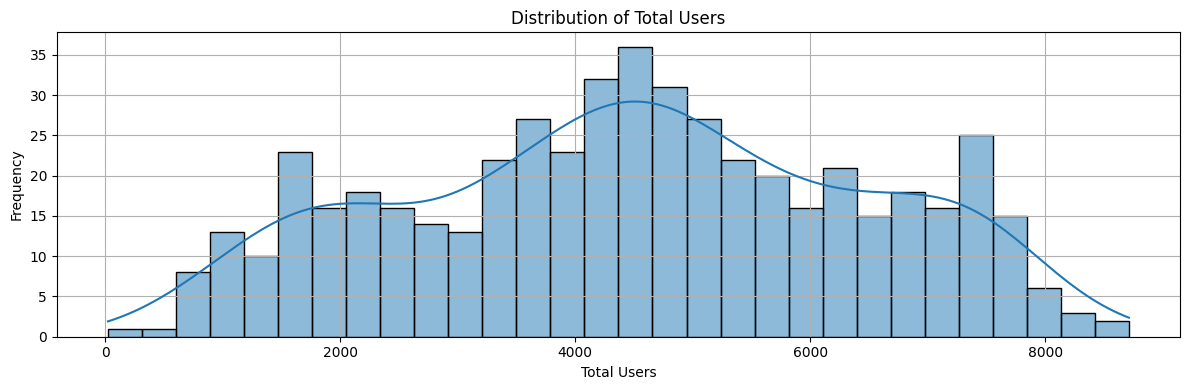

In [364]:
plt.figure(figsize=(12, 4))
sns.histplot(train_df['total_users'], kde=True, bins=30)
plt.title('Distribution of Total Users')
plt.xlabel('Total Users')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

### Categorical Features

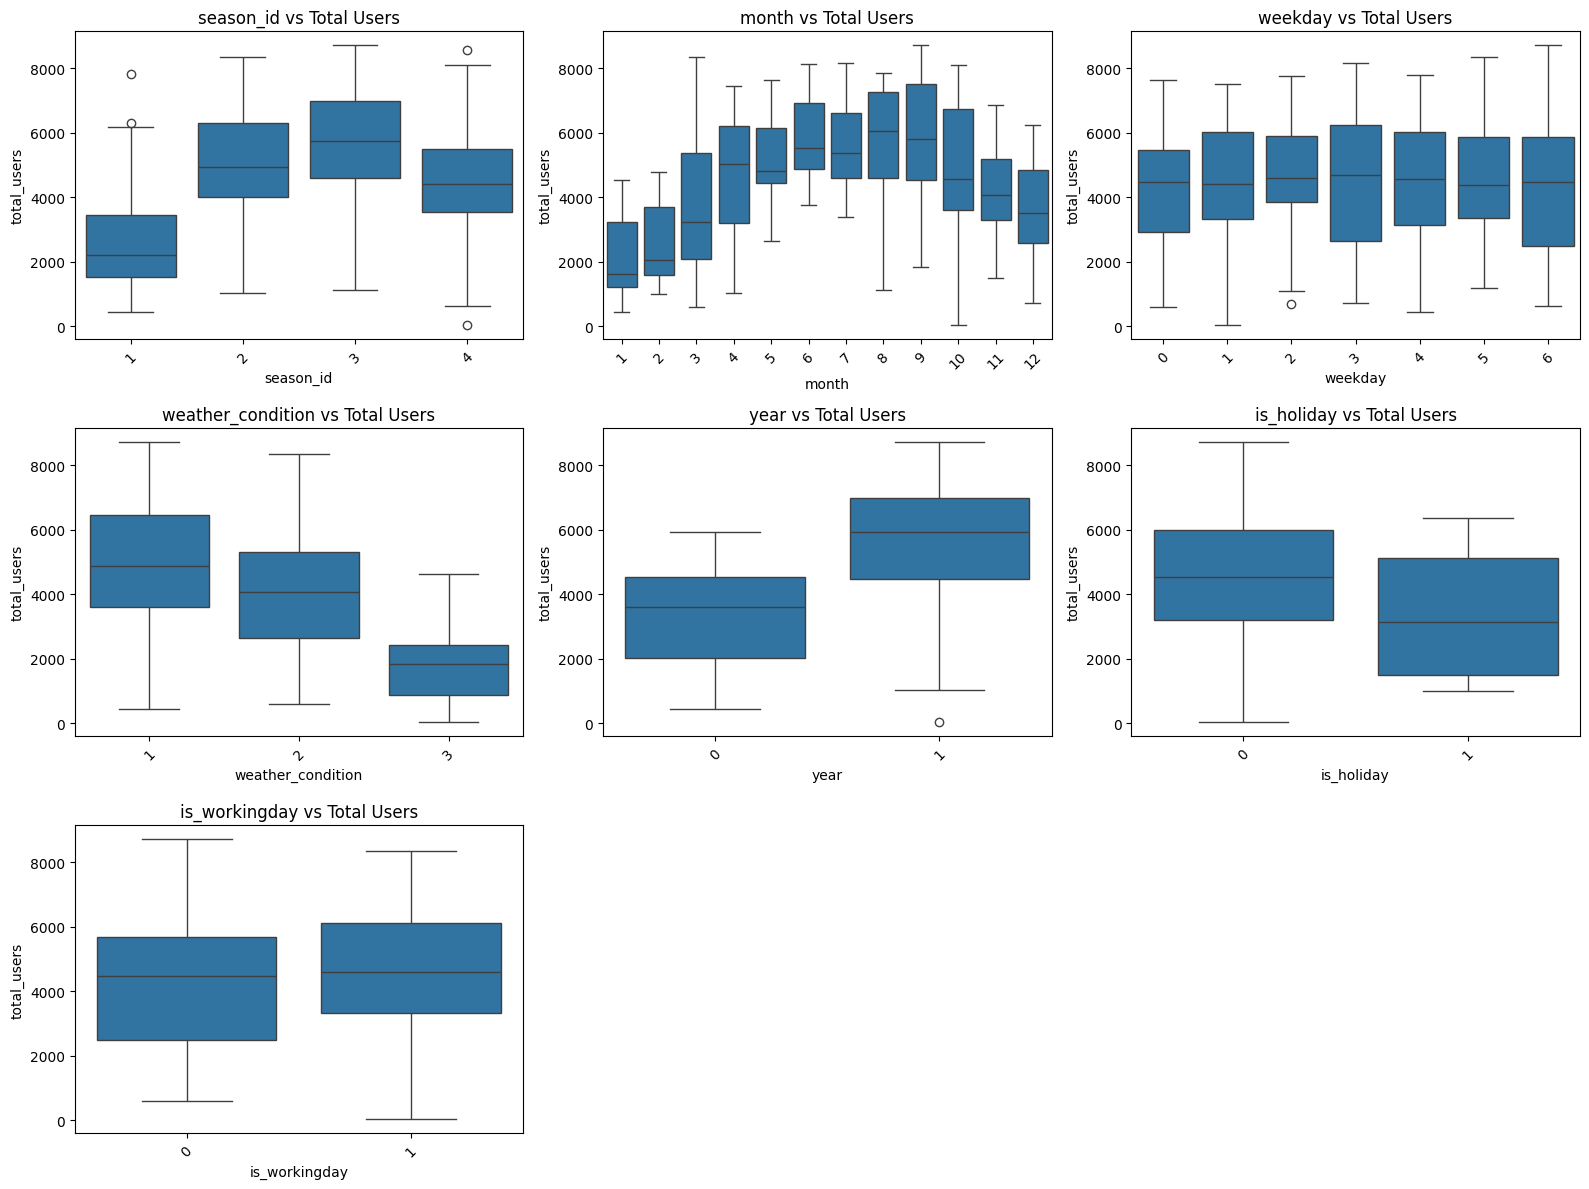

In [365]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=col, y='total_users', data=train_df)
    plt.title(f'{col} vs Total Users')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

### Numerical Features

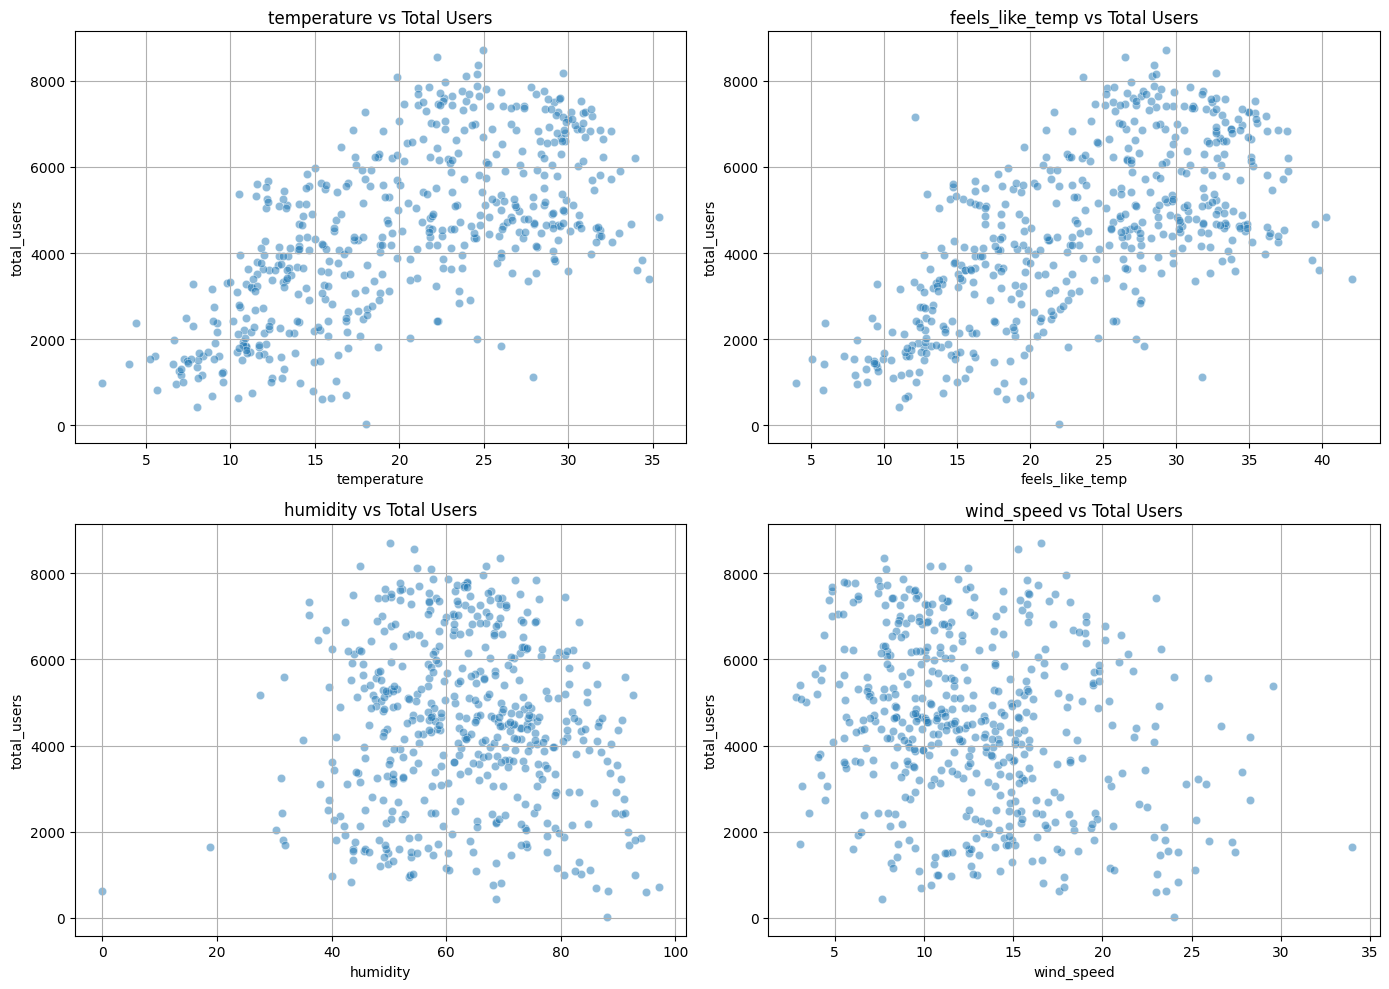

In [366]:
numerical_features = ['temperature', 'feels_like_temp', 'humidity', 'wind_speed']

plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=col, y='total_users', data=train_df, alpha=0.5)
    plt.title(f'{col} vs Total Users')
    plt.grid(True)
    plt.tight_layout()

plt.show()


### Correlation Heatmap

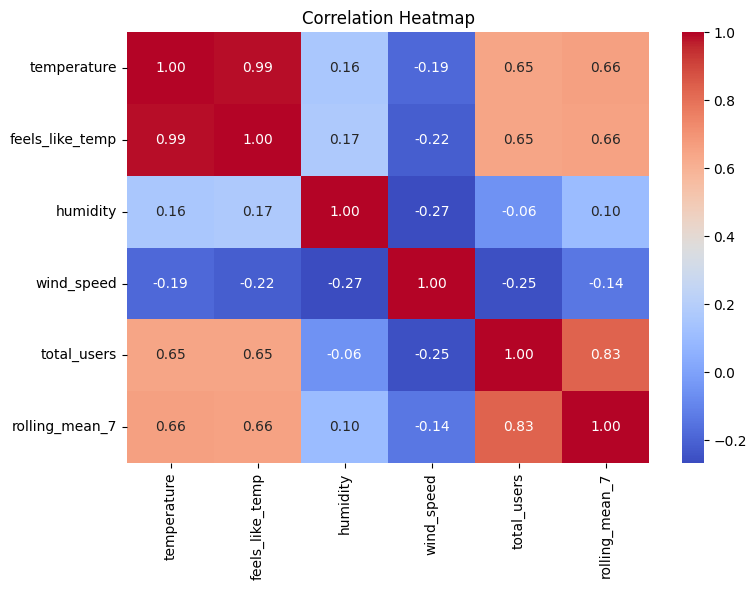

In [367]:
plt.figure(figsize=(8, 6))
numerical_features = train_df.select_dtypes(include=['float64', 'int64']).columns
corr = train_df[numerical_features].corr()

sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

### Summary of Findings

* **Bike rentals increase with temperature**: Warmer weather leads to higher demand.
* **Clear weather results in more rentals**: Usage drops significantly in cloudy, rainy, or snowy conditions.
* **Working days see more rentals than holidays**, reflecting commuting behavior.
* **Spring has the lowest average rentals**, while Summer and Fall see higher usage.
* **Bike usage increased from 2018 to 2019**, as shown by the positive correlation between `year` and `total_users`.
* **Humidity and wind speed are negatively correlated** with rentals, though the effect is moderate.
* **temperature and feels_like_temp are highly correlated**, suggesting that one can be dropped to _avoid multicollinearity_.

## **Data Preprocessing**

### Handling Missing Values

In [368]:
print(train_df.isnull().sum())

season_id            0
year                 0
month                0
is_holiday           0
weekday              0
is_workingday        0
weather_condition    0
temperature          0
feels_like_temp      0
humidity             0
wind_speed           0
total_users          0
rolling_mean_7       7
dtype: int64


The dataset contains no null or missing entries.

### Handling Outliers

In [369]:
def get_outlier_bounds_iqr(df, feature, factor=3):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return lower_bound, upper_bound

outlier_cols = ['temperature', 'feels_like_temp', 'humidity', 'wind_speed']

for col in outlier_cols:
    lb, ub = get_outlier_bounds_iqr(train_df, col)
    train_df[col] = train_df[col].clip(lower=lb, upper=ub)
    test_df[col] = test_df[col].clip(lower=lb, upper=ub)


### Label Encoding

In [370]:
categorical_features = ['season_id', 'month', 'weekday', 'is_holiday', 'is_workingday', 'weather_condition']

for col in categorical_features:
    train_df[col] = train_df[col].astype('category').cat.codes
    test_df[col] = test_df[col].astype('category').cat.codes


## **Feature Engineering**

### Add Features

We create two new features to enrich the dataset:

1. **humidity_wind_interaction**: A new feature that captures the interaction between humidity and wind speed by multiplying them. This can help the model understand how these combined conditions might affect bike rentals.

2. **temp_binned**: A categorical feature created by binning the temperature column into four ranges (Low, Medium, High, Very High). Binning helps the model capture non-linear relationships between temperature and bike rental behavior.

We also created a new column, **rolling_mean_7**, in the cleaning data section before removing the date column.

In [371]:
train_df['humidity_wind_interaction'] = train_df['humidity'] * train_df['wind_speed']
test_df['humidity_wind_interaction'] = test_df['humidity'] * test_df['wind_speed']

# Binning for temperature
temp_bins = [train_df['temperature'].min() - 1, 14.1, 20.8, 27.6, train_df['temperature'].max()]
temp_labels = ['Low', 'Medium', 'High', 'Very High']
train_df['temp_binned'] = pd.cut(train_df['temperature'], bins=temp_bins, labels=temp_labels)
test_df['temp_binned'] = pd.cut(test_df['temperature'], bins=temp_bins, labels=temp_labels)


### reducing multicollinearity

We drop one of temperature or feels_like_temp features to reduce multicollinearity.

In [372]:
drop_columns = ['feels_like_temp']

train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)

train_df.columns

Index(['season_id', 'year', 'month', 'is_holiday', 'weekday', 'is_workingday',
       'weather_condition', 'temperature', 'humidity', 'wind_speed',
       'total_users', 'rolling_mean_7', 'humidity_wind_interaction',
       'temp_binned'],
      dtype='object')

## **Evaluating Different Models**

We compare the following modesl:
1. *Linear Regression*
2. *Decision Tree Regressor*
3. *Random Forest*
4. *Extra Trees Regressor*
5. *Cat Boost Regressor*

In [373]:
X = train_df.drop(columns=['total_users'])
y = train_df['total_users']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

regressors = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42)
}

for name, model in regressors.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")



Linear Regression Performance:
RMSE: 839.75
R² Score: 0.8151

Decision Tree Performance:
RMSE: 1098.86
R² Score: 0.6834

Random Forest Performance:
RMSE: 824.88
R² Score: 0.8216

Extra Trees Performance:
RMSE: 795.05
R² Score: 0.8343

CatBoost Performance:
RMSE: 795.44
R² Score: 0.8341


## **Final Model Training**

We choose **CatBoost Regressor** as our final model. Unlike simpler models like linear regression or decision trees, CatBoost is able to capture complex nonlinear patterns in the data without extensive hyperparameter tuning. It also handles categorical variables natively and robustly deals with missing values, making it particularly well-suited for real-world tabular datasets. These advantages, combined with its strong generalization performance and fast training, make CatBoost the most reliable choice for our bike rental prediction task.

In [374]:
cat_features = ['season_id', 'month', 'weekday', 'is_holiday', 'is_workingday', 'year', 'temp_binned']

cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train, y_train, cat_features=cat_features)
y_pred_cat = cat_model.predict(X_test)

mse_cat = mean_squared_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred_cat)

print("CatBoost Regression Performance:")
print(f"RMSE: {rmse_cat:.2f}")
print(f"R² Score: {r2_cat:.4f}")

CatBoost Regression Performance:
RMSE: 660.40
R² Score: 0.8857


## **Submission File Creation**

In [375]:
X_full = train_df.drop(columns=['total_users'])
y_full = train_df['total_users']

cat_model.fit(X_full, y_full, cat_features=cat_features)
final_preds = cat_model.predict(test_df)

submission = pd.DataFrame({
    'id': test_ids,
    'label': final_preds
})

submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.
